In [4]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras import models, layers, optimizers
import math
from pytrends.request import TrendReq
import pytrends

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


1158
1158


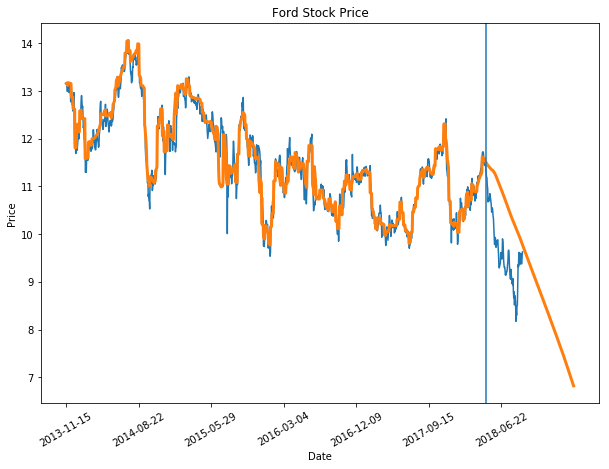

In [28]:
stock_bot_test('F', "Ford")

1158
1158


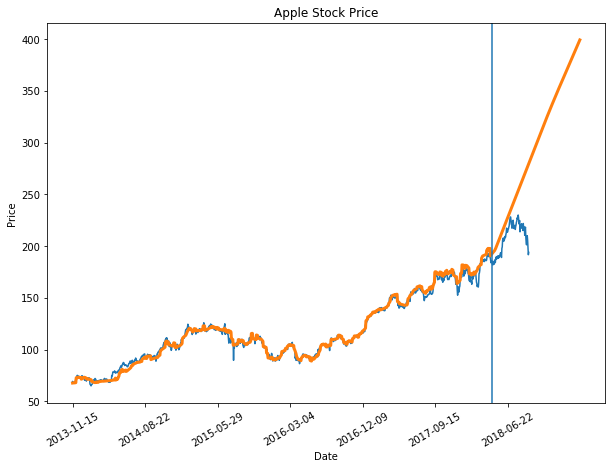

In [29]:
stock_bot_test('AAPL', "Apple")

1158
1158


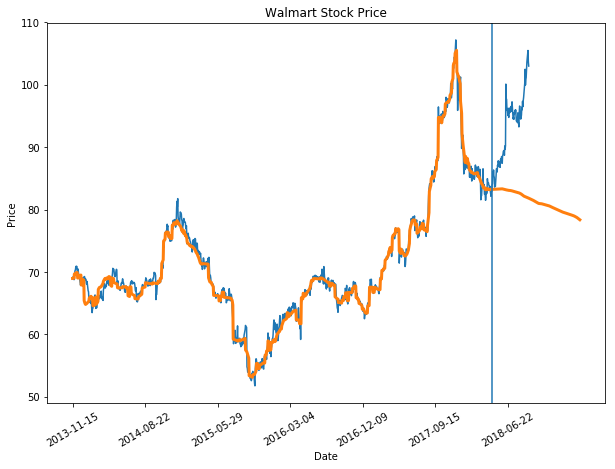

In [30]:
stock_bot_test('WMT', "Walmart")

In [26]:
def stock_bot_test(stock_name, comp_name):
    # ---- Read stock data and Google trends data.
    start = datetime.today() - timedelta(370*5)
    end = datetime.today() - timedelta(1)
    df = web.DataReader(stock_name, 'iex', start, end)
    stock = df.loc[:,'open']
    num = len(stock) - 101
    print(num)
    
    pytrends = TrendReq(hl='en-US', tz=300)
    frame = df.index[0] + ' ' + df.index[-101]
    pytrends.build_payload([comp_name], timeframe=frame, cat=0, geo='US')
    search = pytrends.interest_over_time()
    
    # ---- Rescale trends data to be between -.5 and .5
    trend_max = max(search.values[:,0])
    trend_min = min(search.values[:,0])
    trend_range = trend_max - trend_min
    trend_med = trend_min + (trend_range / 2)
    search_scaled = np.zeros((len(search.values)))
    search_scaled = (search.values[:, 0] - trend_med) / trend_range
    
    # ---- Format input features as (day, trend value)
    x = np.zeros((num, 2))
    ind_cur = 0
    trend_cur = search_scaled[ind_cur]
    for i in range(len(x)):
        x[i, 0] = (i / num) - .7
        if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
            trend_cur = search_scaled[ind_cur]
            ind_cur += 1
        x[i, 1] = trend_cur
    
    # ---- Normalize stock data
    y = stock[:-101]
    scaler = MinMaxScaler()
    y = np.array(stock[:-101]).reshape(len(stock[:-101]), 1)
    scaler = scaler.fit(y)
    y = scaler.transform(y)
    y = y.reshape(len(stock[:-101]))
    print(len(y))
    
    # ---- Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    y = y[shuffle_indices]
    x = x[shuffle_indices]
    
    # ---- Construct network
    network = models.Sequential()
    network.add(layers.Dense(256, activation='relu', input_shape=(2,)))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))
    
    # ---- Compile and run network
    network.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    history = network.fit(x, y, epochs=2000, batch_size=50, verbose=0)
    
    # ---- Build test data set
    xrange = 1400
    x_test = np.zeros((xrange, 2))
    ind_cur = 0
    trend_cur = search_scaled[ind_cur]
    for i in range(len(x_test)):
        x_test[i, 0] = (i / num) - .7
        if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
            trend_cur = search_scaled[ind_cur]
            ind_cur += 1
        x_test[i, 1] = trend_cur
    y_pred = network.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred)[:,0]
    
    num = len(stock)
    
    # ---- Plot the predicted data
    step = 200
    base = datetime.strptime(df.index[0], '%Y-%m-%d')
    xlabels = [(base + timedelta(days=step*x_test*7/5)).date() for x_test in range(0, math.ceil(xrange/step))]
    
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(0, num), stock)
    plt.plot(np.arange(0, xrange), y_pred, lw=3)
    plt.axvline(x=num-101)

    plt.xlabel('Date')
    plt.xticks(np.arange(0, 1400, step=step), xlabels, rotation=30)
    plt.ylabel('Price')
    plt.title(comp_name + ' Stock Price')
    plt.savefig('figures/' + comp_name + '_pred' + '.png')
    plt.show()
    plt.close()

In [5]:
def stock_bot(stock_name, comp_name):
    # ---- Read stock data and Google trends data.
    start = datetime.today() - timedelta(370*5)
    end = datetime.today() - timedelta(1)
    df = web.DataReader(stock_name, 'iex', start, end)
    stock = df.loc[:,'open']
    num = len(stock)
    print(num)
    
    pytrends = TrendReq(hl='en-US', tz=300)
    frame = df.index[0] + ' ' + df.index[-1]
    pytrends.build_payload([comp_name], timeframe=frame, cat=0, geo='US')
    search = pytrends.interest_over_time()
    
    # ---- Rescale trends data to be between -.5 and .5
    trend_max = max(search.values[:,0])
    trend_min = min(search.values[:,0])
    trend_range = trend_max - trend_min
    trend_med = trend_min + (trend_range / 2)
    search_scaled = np.zeros((len(search.values)))
    search_scaled = (search.values[:, 0] - trend_med) / trend_range
    
    # ---- Format input features as (day, trend value)
    x = np.zeros((num, 2))
    ind_cur = 0
    trend_cur = search_scaled[ind_cur]
    for i in range(len(x)):
        x[i, 0] = (i / num) - .7
        if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
            trend_cur = search_scaled[ind_cur]
            ind_cur += 1
        x[i, 1] = trend_cur
    
    # ---- Normalize stock data
    y = stock
    scaler = MinMaxScaler()
    y = np.array(stock).reshape(len(stock), 1)
    scaler = scaler.fit(y)
    y = scaler.transform(y)
    y = y.reshape(len(stock))
    
    # ---- Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    y = y[shuffle_indices]
    x = x[shuffle_indices]
    
    # ---- Construct network
    network = models.Sequential()
    network.add(layers.Dense(256, activation='relu', input_shape=(2,)))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))
    
    # ---- Compile and run network
    network.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    history = network.fit(x, y, epochs=2000, batch_size=50, verbose=1)
    
    # ---- Build test data set
    xrange = 1259
    x_test = np.zeros((xrange, 2))
    ind_cur = 0
    trend_cur = search_scaled[ind_cur]
    for i in range(len(x_test)):
        x_test[i, 0] = (i / num) - .7
        if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
            trend_cur = search_scaled[ind_cur]
            ind_cur += 1
        x_test[i, 1] = trend_cur
    y_pred = network.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred)[:,0]
    
    # ---- Plot the predicted data
    step = 200
    base = datetime.strptime(df.index[0], '%Y-%m-%d')
    xlabels = [(base + timedelta(days=step*x_test*7/5)).date() for x_test in range(0, math.ceil(xrange/step))]
    
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(0, num), stock)
    plt.plot(np.arange(0, xrange), y_pred, lw=3)

    plt.xlabel('Date')
    plt.xticks(np.arange(0, 1400, step=step), xlabels, rotation=30)
    plt.ylabel('Price')
    plt.title(comp_name + ' Stock Price')
    plt.savefig('figures/' + comp_name + '_pred' + '.png')
    plt.show()
    plt.close()

In [3]:
def stock_bot(stock_name, comp_name):
    start = datetime.today() - timedelta(370*5)
    end = datetime.today() - timedelta(1)
    df = web.DataReader(stock_name, 'iex', start, end)
    stock = df.loc[:,'open']
    num = len(stock)
    print(num)
    
    pytrends = TrendReq(hl='en-US', tz=300)
    frame = df.index[0] + ' ' + df.index[-1]
    pytrends.build_payload([comp_name], timeframe=frame, cat=0, geo='US')
    search = pytrends.interest_over_time()
    
    trend_max = max(search.values[:,0])
    trend_min = min(search.values[:,0])
    trend_range = trend_max - trend_min
    trend_med = trend_min + (trend_range / 2)
    search_scaled = np.zeros((len(search.values)))
    search_scaled = (search.values[:, 0] - trend_med) / trend_range

    x = np.zeros((num, 2))
    ind_cur = 0
    trend_cur = search_scaled[ind_cur]
    for i in range(len(x)):
        x[i, 0] = (i / num) - .7
        if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
            trend_cur = search_scaled[ind_cur]
            ind_cur += 1
        x[i, 1] = trend_cur

    y = stock
    scaler = MinMaxScaler()
    y = np.array(stock).reshape(len(stock), 1)
    scaler = scaler.fit(y)
    y = scaler.transform(y)
    y = y.reshape(len(stock))

    shuffle_indices = np.random.permutation(np.arange(len(y)))
    y = y[shuffle_indices]
    x = x[shuffle_indices]

    network = models.Sequential()
    network.add(layers.Dense(256, activation='relu', input_shape=(2,)))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dense(256, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(128, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))
    network.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    
    for k in range(10):
        history = network.fit(x, y, epochs=2, batch_size=50, verbose=0)

        xrange = 1400
        x_test = np.zeros((xrange, 2))
        ind_cur = 0
        trend_cur = search_scaled[ind_cur]
        for i in range(len(x_test)):
            x_test[i, 0] = (i / num) - .7
            if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
                trend_cur = search_scaled[ind_cur]
                ind_cur += 1
            x_test[i, 1] = trend_cur
        y_pred = network.predict(x_test)
        y_pred = scaler.inverse_transform(y_pred)[:,0]

        step = 200
        base = datetime.strptime(df.index[0], '%Y-%m-%d')
        xlabels = [(base + timedelta(days=step*x_test*7/5)).date() for x_test in range(0, math.ceil(xrange/step))]

        plt.figure(figsize=(10,7))
        plt.plot(np.arange(0, num), stock)
        plt.plot(np.arange(0, xrange), y_pred, lw=3)

        plt.xlabel('Date')
        plt.xticks(np.arange(0, 1400, step=step), xlabels, rotation=30)
        plt.ylabel('Price')
        plt.title(comp_name + ' Stock Price; Epoch ' + str(2*k))
        plt.savefig('figures/' + stock_name + '/' + comp_name + '_e' + str(2*k) + '.png')
        #plt.show()
        plt.close()
        
    for k in range(16):
        history = network.fit(x, y, epochs=5, batch_size=50, verbose=0)

        xrange = 1400
        x_test = np.zeros((xrange, 2))
        ind_cur = 0
        trend_cur = search_scaled[ind_cur]
        for i in range(len(x_test)):
            x_test[i, 0] = (i / num) - .7
            if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
                trend_cur = search_scaled[ind_cur]
                ind_cur += 1
            x_test[i, 1] = trend_cur
        y_pred = network.predict(x_test)
        y_pred = scaler.inverse_transform(y_pred)[:,0]

        step = 200
        base = datetime.strptime(df.index[0], '%Y-%m-%d')
        xlabels = [(base + timedelta(days=step*x_test*7/5)).date() for x_test in range(0, math.ceil(xrange/step))]

        plt.figure(figsize=(10,7))
        plt.plot(np.arange(0, num), stock)
        plt.plot(np.arange(0, xrange), y_pred, lw=3)

        plt.xlabel('Date')
        plt.xticks(np.arange(0, 1400, step=step), xlabels, rotation=30)
        plt.ylabel('Price')
        plt.title(comp_name + ' Stock Price; Epoch ' + str(5*k+20))
        plt.savefig('figures/' + stock_name + '/' + comp_name + '_e' + str(5*k+20) + '.png')
        #plt.show()
        plt.close()
        
    for k in range(16):
        history = network.fit(x, y, epochs=25, batch_size=50, verbose=0)

        xrange = 1400
        x_test = np.zeros((xrange, 2))
        ind_cur = 0
        trend_cur = search_scaled[ind_cur]
        for i in range(len(x_test)):
            x_test[i, 0] = (i / num) - .7
            if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
                trend_cur = search_scaled[ind_cur]
                ind_cur += 1
            x_test[i, 1] = trend_cur
        y_pred = network.predict(x_test)
        y_pred = scaler.inverse_transform(y_pred)[:,0]

        step = 200
        base = datetime.strptime(df.index[0], '%Y-%m-%d')
        xlabels = [(base + timedelta(days=step*x_test*7/5)).date() for x_test in range(0, math.ceil(xrange/step))]

        plt.figure(figsize=(10,7))
        plt.plot(np.arange(0, num), stock)
        plt.plot(np.arange(0, xrange), y_pred, lw=3)

        plt.xlabel('Date')
        plt.xticks(np.arange(0, 1400, step=step), xlabels, rotation=30)
        plt.ylabel('Price')
        plt.title(comp_name + ' Stock Price; Epoch ' + str(25*k+100))
        plt.savefig('figures/' + stock_name + '/' + comp_name + '_e' + str(25*k+100) + '.png')
        #plt.show()
        plt.close()
        
    for k in range(15):
        history = network.fit(x, y, epochs=100, batch_size=50, verbose=0)

        xrange = 1400
        x_test = np.zeros((xrange, 2))
        ind_cur = 0
        trend_cur = search_scaled[ind_cur]
        for i in range(len(x_test)):
            x_test[i, 0] = (i / num) - .7
            if (ind_cur < len(search_scaled) and search.index[ind_cur].year == int(df.index[i][:4]) and search.index[ind_cur].month == int(df.index[i][5:7]) and search.index[ind_cur].day <= int(df.index[i][8:])+2 and search.index[ind_cur].day >= int(df.index[i][8:])-2):
                trend_cur = search_scaled[ind_cur]
                ind_cur += 1
            x_test[i, 1] = trend_cur
        y_pred = network.predict(x_test)
        y_pred = scaler.inverse_transform(y_pred)[:,0]

        step = 200
        base = datetime.strptime(df.index[0], '%Y-%m-%d')
        xlabels = [(base + timedelta(days=step*x_test*7/5)).date() for x_test in range(0, math.ceil(xrange/step))]

        plt.figure(figsize=(10,7))
        plt.plot(np.arange(0, num), stock)
        plt.plot(np.arange(0, xrange), y_pred, lw=3)

        plt.xlabel('Date')
        plt.xticks(np.arange(0, 1400, step=step), xlabels, rotation=30)
        plt.ylabel('Price')
        plt.title(comp_name + ' Stock Price; Epoch ' + str(100*k+500))
        plt.savefig('figures/' + stock_name + '/' + comp_name + '_e' + str(100*k+500) + '.png')
        #plt.show()
        plt.close()